#分类回归树-CATR

In [1]:
from numpy import *

class treeNode():
    def __init__(self,feat,val,right,left):
        featureToSplithOn=feat
        valueOfSplit=val
        rightBranch=right
        leftBranch=left

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = map(float,curLine) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

In [2]:
testMat=mat(eye(4))
print testMat

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [3]:
mat0,mat1=binSplitDataSet(testMat,1,0.5)
print mat0
print mat1

[[ 0.  1.  0.  0.]]
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [4]:
def regLeaf(dataSet):#returns the value used for each leaf
    return mean(dataSet[:,-1])

def regErr(dataSet):
    return var(dataSet[:,-1]) * shape(dataSet)[0]

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    tolS = ops[0]; tolN = ops[1]
    #if all the target variables are the same value: quit and return value
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1: #exit cond 1
        return None, leafType(dataSet)
    m,n = shape(dataSet)
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = inf; bestIndex = 0; bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set((dataSet[:,featIndex].T.A.tolist())[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS: 
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    #if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS: 
        return None, leafType(dataSet) #exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):  #exit cond 3
        return None, leafType(dataSet)
    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split
    
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):#assume dataSet is NumPy Mat so we can array filtering
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    if feat == None: return val #if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotmyMat(myMat):
    fig=plt.scatter(myMat[:,0].flatten().A[0],myMat[:,1].flatten().A[0],s=2,c='blue')

In [6]:
treeNode = dict(boxstyle="sawtooth",fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    inkeys = myTree.keys()
    for key in inkeys:
        if type(myTree[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(myTree[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree): 
    maxDepth = 0
    inkeys = myTree.keys()
    for key in inkeys:
        if type(myTree[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(myTree[key])
        else:   thisDepth = 1
    if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)
    
def plotTree(myTree, parentPt, nodeTxt,firstStr="D"):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, treeNode)
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    
    for nodestr in myTree.keys():
        secondDict = myTree[nodestr]
        if type(secondDict).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict,cntrPt,str(nodestr))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict, (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(nodestr))
    plotTree.yOff = plotTree.yOff + 0.5/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

{'spInd': 0, 'spVal': 0.48813, 'right': -0.044650285714285719, 'left': 1.0180967672413792}


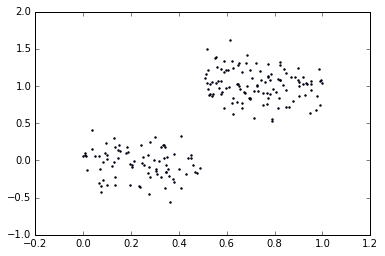

In [7]:
myDat=loadDataSet('ex00.txt')
myMat=mat(myDat)
myTree=createTree(myMat)
plotmyMat(myMat)
print myTree

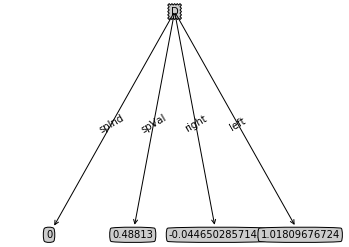

In [8]:
createPlot(myTree)

{'spInd': 1, 'spVal': 0.39435, 'right': {'spInd': 1, 'spVal': 0.197834, 'right': -0.023838155555555553, 'left': 1.0289583666666666}, 'left': {'spInd': 1, 'spVal': 0.582002, 'right': 1.980035071428571, 'left': {'spInd': 1, 'spVal': 0.797583, 'right': 2.9836209534883724, 'left': 3.9871631999999999}}}


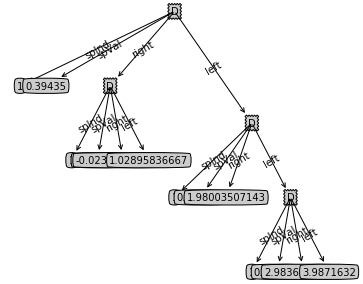

In [9]:
myDat1=loadDataSet('ex0.txt')
myMat1=mat(myDat1)
myTree1=createTree(myMat1)
#plotmyMat(myMat1)
print myTree1
createPlot(myTree1)

In [10]:
print createTree(myMat1,ops=(0,1))

{'spInd': 1, 'spVal': 0.39435, 'right': {'spInd': 1, 'spVal': 0.197834, 'right': {'spInd': 1, 'spVal': 0.148654, 'right': {'spInd': 1, 'spVal': 0.143143, 'right': {'spInd': 1, 'spVal': 0.004327, 'right': 0.188975, 'left': {'spInd': 1, 'spVal': 0.052031, 'right': {'spInd': 1, 'spVal': 0.04127, 'right': {'spInd': 1, 'spVal': 0.018883, 'right': {'spInd': 1, 'spVal': 0.017774, 'right': {'spInd': 1, 'spVal': 0.009493, 'right': -0.0063379999999999999, 'left': {'spInd': 1, 'spVal': 0.012003, 'right': -0.217283, 'left': {'spInd': 1, 'spVal': 0.016241, 'right': {'spInd': 1, 'spVal': 0.013643, 'right': -0.067697999999999994, 'left': -0.063214999999999993}, 'left': -0.116803}}}, 'left': -0.30057699999999998}, 'left': {'spInd': 1, 'spVal': 0.032469, 'right': 0.11022899999999999, 'left': 0.130713}}, 'left': {'spInd': 1, 'spVal': 0.044136, 'right': -0.53770600000000002, 'left': -0.16470299999999999}}, 'left': {'spInd': 1, 'spVal': 0.057534, 'right': {'spInd': 1, 'spVal': 0.056934, 'right': 0.2346330

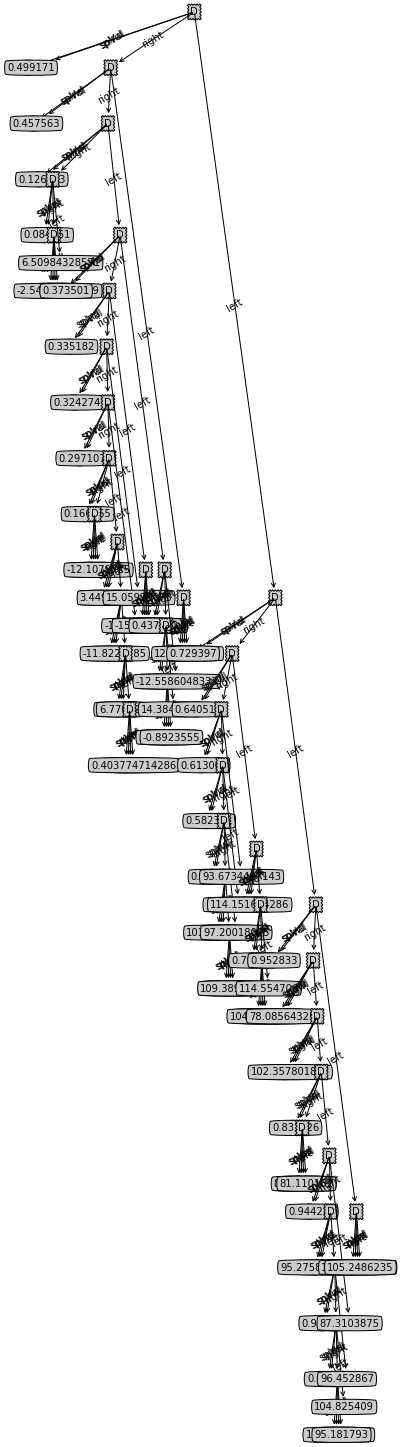

In [11]:
myDat2=loadDataSet('ex2.txt')
myMat2=mat(myDat2)
myTree2=createTree(myMat2)
#print myTree2
createPlot(myTree2)

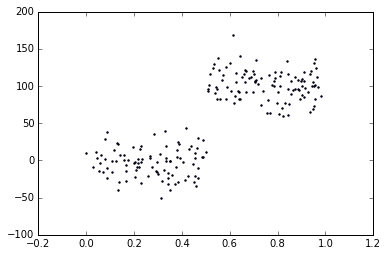

In [12]:
plotmyMat(myMat2)

In [13]:
createTree(myMat2,ops=(10000,4))

{'left': 101.35815937735848,
 'right': -2.6377193297872341,
 'spInd': 0,
 'spVal': 0.499171}

In [14]:
def isTree(obj):
    return (type(obj).__name__=='dict')

def getMean(tree):
    if isTree(tree['right']): tree['right'] = getMean(tree['right'])
    if isTree(tree['left']): tree['left'] = getMean(tree['left'])
    return (tree['left']+tree['right'])/2.0
    
def prune(tree, testData):
    if shape(testData)[0] == 0: return getMean(tree) #if we have no test data collapse the tree
    if (isTree(tree['right']) or isTree(tree['left'])):#if the branches are not trees try to prune them
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']): tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']): tree['right'] =  prune(tree['right'], rSet)
    #if they are now both leafs, see if we can merge them
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        errorNoMerge = sum(power(lSet[:,-1] - tree['left'],2)) +\
            sum(power(rSet[:,-1] - tree['right'],2))
        treeMean = (tree['left']+tree['right'])/2.0
        errorMerge = sum(power(testData[:,-1] - treeMean,2))
        if errorMerge < errorNoMerge: 
            #print "merging"
            return treeMean
        else: return tree
    else: return tree

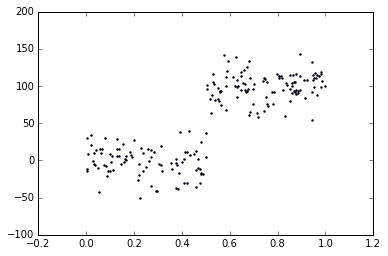

In [15]:
myTree=createTree(myMat2,ops=(0,1))
myDatTest=loadDataSet('ex2test.txt')
myMat2Test=mat(myDatTest)
pTree=prune(myTree,myMat2Test)
plotmyMat(myMat2Test)

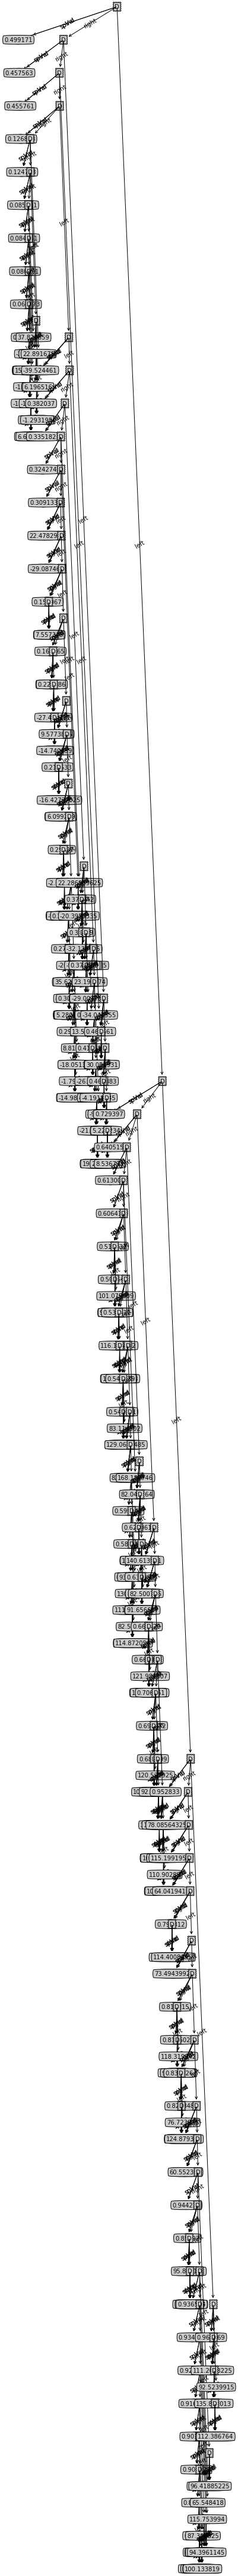

In [16]:
createPlot(pTree)

In [17]:
def linearSolve(dataSet):   #helper function used in two places
    m,n = shape(dataSet)
    X = mat(ones((m,n))); Y = mat(ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1]; Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

def modelLeaf(dataSet):#create linear model and return coeficients
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(power(Y - yHat,2))


In [18]:
myMat2=mat(loadDataSet('exp2.txt'))
createTree(myMat2,modelLeaf,modelErr,(1,10))

{'left': matrix([[  1.69855694e-03],
         [  1.19647739e+01]]), 'right': matrix([[ 3.46877936],
         [ 1.18521743]]), 'spInd': 0, 'spVal': 0.285477}

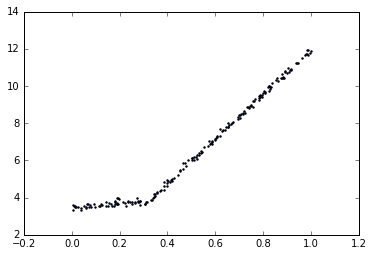

In [19]:
plotmyMat(myMat2)

In [20]:
def regTreeEval(model, inDat):
    return float(model)

def modelTreeEval(model, inDat):
    n = shape(inDat)[1]
    X = mat(ones((1,n+1)))
    X[:,1:n+1]=inDat
    return float(X*model)

def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree): return modelEval(tree, inData)
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']): return treeForeCast(tree['left'], inData, modelEval)
        else: return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']): return treeForeCast(tree['right'], inData, modelEval)
        else: return modelEval(tree['right'], inData)
        
def createForeCast(tree, testData, modelEval=regTreeEval):
    m=len(testData)
    yHat = mat(zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, mat(testData[i]), modelEval)
    return yHat

In [21]:
trainMat=mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat=mat(loadDataSet('bikeSpeedVsIq_test.txt'))
myTree=createTree(trainMat,ops=(1,20))
yHat=createForeCast(myTree,testMat[:,0])
corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.96408523182221406

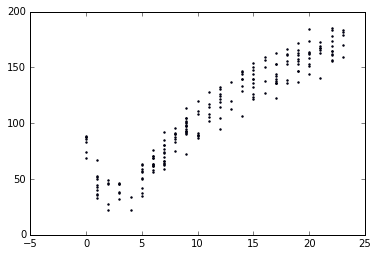

In [22]:
plotmyMat(trainMat)

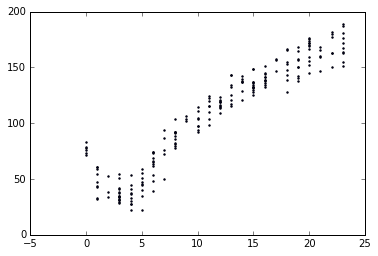

In [23]:
plotmyMat(testMat)

In [24]:
myTree=createTree(trainMat,modelLeaf,modelErr,(1,20))
yHat=createForeCast(myTree,testMat[:,0],modelTreeEval)
corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.97604121913806374

In [25]:
ws,X,Y=linearSolve(trainMat)
print ws

[[ 37.58916794]
 [  6.18978355]]


In [26]:
for i in range(shape(testMat)[0]):
    yHat[i]=testMat[i,0]+ws[0,0]
    
corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.94346842356747707

In [27]:
from Tkinter import *
root =Tk()
myLabel=Label(root,text="hello")
myLabel.grid()
root.mainloop()

In [29]:
from numpy import *

from Tkinter import *

import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

%matplotlib inline

def reDraw(tolS,tolN):
    reDraw.f.clf()        # clear the figure
    reDraw.a = reDraw.f.add_subplot(111)
    if chkBtnVar.get():
        if tolN < 2: tolN = 2
        myTree=createTree(reDraw.rawDat, regTrees.modelLeaf, modelErr, (tolS,tolN))
        yHat = createForeCast(myTree, reDraw.testDat, modelTreeEval)
    else:
        myTree=createTree(reDraw.rawDat, ops=(tolS,tolN))
        yHat = createForeCast(myTree, reDraw.testDat)
    reDraw.a.scatter(reDraw.rawDat[:,0], reDraw.rawDat[:,1], s=5) #use scatter for data set
    reDraw.a.plot(reDraw.testDat, yHat, linewidth=2.0) #use plot for yHat
    reDraw.canvas.show()

def getInputs():
    try: tolN = int(tolNentry.get())
    except: 
        tolN = 10 
        print "enter Integer for tolN"
        tolNentry.delete(0, END)
        tolNentry.insert(0,'10')
    try: tolS = float(tolSentry.get())
    except: 
        tolS = 1.0 
        print "enter Float for tolS"
        tolSentry.delete(0, END)
        tolSentry.insert(0,'1.0')
    return tolN,tolS

def drawNewTree():
    tolN,tolS = getInputs()#get values from Entry boxes
    reDraw(tolS,tolN)

root=Tk()

reDraw.f = Figure(figsize=(5,4), dpi=100) #create canvas
reDraw.canvas = FigureCanvasTkAgg(reDraw.f, master=root)
reDraw.canvas.show()
reDraw.canvas.get_tk_widget().grid(row=0, columnspan=3)

Label(root, text="tolN").grid(row=1, column=0)
tolNentry = Entry(root)
tolNentry.grid(row=1, column=1)
tolNentry.insert(0,'10')
Label(root, text="tolS").grid(row=2, column=0)
tolSentry = Entry(root)
tolSentry.grid(row=2, column=1)
tolSentry.insert(0,'1.0')
Button(root, text="ReDraw", command=drawNewTree).grid(row=1, column=2, rowspan=3)
#Button(root, text='Quit', fg="black", command=root.quit).grid(row=1,column=2)
chkBtnVar = IntVar()
chkBtn = Checkbutton(root, text="Model Tree", variable = chkBtnVar)
chkBtn.grid(row=3, column=0, columnspan=2)

reDraw.rawDat = mat(loadDataSet('sine.txt'))
reDraw.testDat = arange(min(reDraw.rawDat[:,0]),max(reDraw.rawDat[:,0]),0.01)
reDraw(1.0, 10)

root.mainloop()